In [1]:
from instagramy.plugins.analysis import analyze_users_popularity
from instagramy import InstagramUser
from instagramy import InstagramPost
import matplotlib.pyplot as plt
from textblob import TextBlob
from datetime import datetime
import pandas as pd
import numpy as np

In [3]:
def create_user_df(username):
    """
    Funcion que recopila la informacion de las
    ultimas 10 publicaciones de una cuenta especifica.
    """
    user = InstagramUser(username, from_cache=True)
    likes=[] # Cantidad de likes
    comments_count=[] # Cantidad de comentarios
    shortcode=[] # Codigo de la publicacion
    timestamp=[] # Fecha de publicacion
    
    for post in user.posts:
        likes.append(post.likes)
        comments_count.append(post.comments)
        shortcode.append(post.shortcode)
        timestamp.append(datetime.fromtimestamp(post.timestamp)) 

    df = pd.DataFrame(
        list(
            zip(shortcode, timestamp, likes, comments_count)
        ),
        columns=['shortcode', 'timestamp', 'likes', 'comments_count']
    )
    
    df.insert(loc=0, column='username', value=username)
    return df

In [4]:
# Creación primer df
data = create_user_df('topman')
# Lista de cuentas para hacer el analisis
best_sellers = ['wholeplanet','mango','harrods','target']

In [5]:
def concat_posts(users, df):
    """
    Función para concatenar la información adquirida
    para cada usuario
    """
    for user in users:
        df_new = create_user_df(user)
        df = pd.concat([df,df_new])
    return df

In [6]:
data = concat_posts(best_sellers, data)

In [7]:
def apply_sentiment(shortcode):
    """
    Función para realizar el análisis de sentimientos
    utilizando TextBlob
    """
    # Se obtienen los primeros comentarios de la publicación
    post = InstagramPost(shortcode, from_cache=True)
    edges = post.post_data['edge_media_to_parent_comment']['edges']
    comments = []
    for edge in edges:
        comments.append(edge['node']['text'])
    # Se calcula la polaridad y subjetividad para cada comentario
    polarity=[]
    subjectivity=[]
    for comment in comments:
        test = TextBlob(comment)
        pol = test.sentiment.polarity
        sub = test.sentiment.subjectivity
        # Si el comentario es neutral se ignora
        if pol != 0:
            polarity.append(pol)
            subjectivity.append(sub)
    if len(polarity) == 0:
        return 0,0
    # Se retorna el promedio de polaridad para la publicacion
    # junto con la subjetividad
    return np.mean(polarity), np.mean(subjectivity)
    

In [8]:
# Calculamos la polaridad para todas las publicaciones
data['polarity'] = data.apply(lambda row: apply_sentiment(row['shortcode'])[0], axis=1)

In [9]:
# Calculamos la subjetividad para todas las publicaciones
data['subjectivity'] = data.apply(lambda row: apply_sentiment(row['shortcode'])[1], axis=1)

In [10]:
data.head()

,username,shortcode,timestamp,likes,comments_count,polarity,subjectivity
0,topman,CRwlZQBA3p6,2021-07-25 12:49:28,253,2,0.7,0.6
1,topman,CRtSGX7gFEU,2021-07-24 06:03:09,390,1,0.0,0.0
2,topman,CRq9WM3A0Ol,2021-07-23 08:23:20,775,1,0.0,0.0
3,topman,CRoplEgghxy,2021-07-22 10:52:07,929,2,0.6,1.0
4,topman,CRmC6jYgwhB,2021-07-21 10:35:47,860,2,0.7,0.6


In [11]:
def analyze_users_popularity_from_cache(usernames: list):
    """ Functions return the required data to Analze Instagram users """

    followers = []
    following = []
    posts = []
    for username in usernames:
        user = InstagramUser(username, from_cache=True)
        followers.append(user.number_of_followers)
        following.append(user.number_of_followings)
        posts.append(user.number_of_posts)
    data = {
        "Usernames": usernames,
        "Followers": followers,
        "Following": following,
        "Posts": posts,
    }
    return data

In [12]:
# Utilizamos el plugin para obtener los datos generales de las cuentas
users = analyze_users_popularity_from_cache(best_sellers+['topman'])
data_best_sellers = pd.DataFrame(users)

In [13]:
data_best_sellers.head()

,Usernames,Followers,Following,Posts
0,wholeplanet,13034,3544,857
1,mango,12348301,425,4666
2,harrods,1746455,247,8070
3,target,4567646,5092,1935
4,topman,746259,30,5134


In [14]:
def get_category(username):
    """
    Función para obtener la categoría a la
    que pertenece el usuario
    """
    user = InstagramUser(username, from_cache=True) 
    return user.user_data['category_name']

In [15]:
# Se agregan las categorías a la tabla
data_best_sellers['Category'] = data_best_sellers.apply(lambda row: get_category(row['Usernames']), axis = 1)

In [16]:
data_best_sellers.head(10)

,Usernames,Followers,Following,Posts,Category
0,wholeplanet,13034,3544,857,None
1,mango,12348301,425,4666,Clothing (Brand)
2,harrods,1746455,247,8070,Shopping & Retail
3,target,4567646,5092,1935,Shopping & Retail
4,topman,746259,30,5134,None


In [17]:
# Unión de todos los datos
data_completed = data.set_index('username').join(data_best_sellers.set_index('Usernames'))

In [18]:
data_completed = data_completed.reset_index()
data_completed.head(10)

,index,shortcode,timestamp,likes,comments_count,polarity,subjectivity,Followers,Following,Posts,Category
0,harrods,CRvyZjcHPMy,2021-07-25 05:23:52,2516,17,0.604688,0.871875,1746455,247,8070,Shopping & Retail
1,harrods,CRtEPtUHrVW,2021-07-24 04:02:05,4491,67,0.468750,0.662500,1746455,247,8070,Shopping & Retail
2,harrods,CRrWjzfIP4y,2021-07-23 12:04:15,830,74,0.146667,0.760000,1746455,247,8070,Shopping & Retail
3,harrods,CRquizLHtlV,2021-07-23 06:13:59,834,13,1.000000,1.000000,1746455,247,8070,Shopping & Retail
4,harrods,CRo-wFCHD1K,2021-07-22 13:57:19,936,12,0.380000,0.480000,1746455,247,8070,Shopping & Retail
5,harrods,CRoceBuIDH_,2021-07-22 08:57:34,1419,15,0.459375,0.768750,1746455,247,8070,Shopping & Retail
6,harrods,CRmGEenI2qz,2021-07-21 11:03:21,3923,21,0.492857,0.814286,1746455,247,8070,Shopping & Retail
7,harrods,CRjijNBIeSM,2021-07-20 11:14:29,1500,14,0.750000,0.800000,1746455,247,8070,Shopping & Retail
8,harrods,CRi4epgnEb7,2021-07-20 05:06:52,1501,11,0.550000,1.000000,1746455,247,8070,Shopping & Retail
9,harrods,CRg8XwioYjk,2021-07-19 11:02:24,4966,69,0.556250,0.675000,1746455,247,8070,Shopping & Retail


In [19]:
data_completed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   index           60 non-null     object        
 1   shortcode       60 non-null     object        
 2   timestamp       60 non-null     datetime64[ns]
 3   likes           60 non-null     int64         
 4   comments_count  60 non-null     int64         
 5   polarity        60 non-null     float64       
 6   subjectivity    60 non-null     float64       
 7   Followers       60 non-null     int64         
 8   Following       60 non-null     int64         
 9   Posts           60 non-null     int64         
 10  Category        36 non-null     object        
dtypes: datetime64[ns](1), float64(2), int64(5), object(3)
memory usage: 5.3+ KB


In [20]:
# Se calculan el promedio de likes para definir 
# cuáles son las mejores cuentas para mostrar
# los resultados
means = []
for account in best_sellers+['topman']:
    filt = data_completed.loc[data_completed['index'] == account]
    mean_likes = np.mean(filt['likes'])
    means.append([mean_likes, account])
means.sort(reverse=True)

In [21]:
means

[[24396.5, 'target'],
 [7912.333333333333, 'mango'],
 [2407.5, 'harrods'],
 [1027.6666666666667, 'topman'],
 [48.833333333333336, 'wholeplanet']]

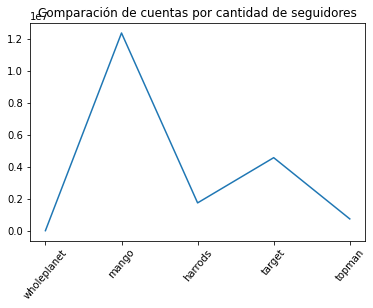

In [22]:
plt.plot(data_best_sellers.set_index('Usernames')['Followers']);
plt.xticks(rotation = 50);
plt.title('Comparación de cuentas por cantidad de seguidores');

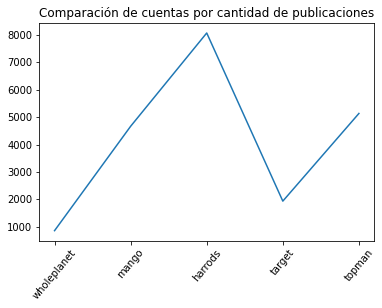

In [23]:
plt.plot(data_best_sellers.set_index('Usernames')['Posts']);
plt.xticks(rotation = 50);
plt.title('Comparación de cuentas por cantidad de publicaciones');

In [24]:
# Se toman los datos especificos de Target
target = data_completed.loc[data_completed['index'] == 'target']

In [25]:
target.head()

,index,shortcode,timestamp,likes,comments_count,polarity,subjectivity,Followers,Following,Posts,Category
24,target,CRwoK6bglck,2021-07-25 13:14:28,1365,12,0.175000,0.325000,4567646,5092,1935,Shopping & Retail
25,target,CRt2XLvAaY8,2021-07-24 11:25:29,7015,136,0.316005,0.618915,4567646,5092,1935,Shopping & Retail
26,target,CRrVh-fgHOA,2021-07-23 11:55:27,60688,1296,0.487388,0.643065,4567646,5092,1935,Shopping & Retail
27,target,CRpPa4HAhFz,2021-07-22 16:23:35,2253,36,0.421205,0.650298,4567646,5092,1935,Shopping & Retail
28,target,CRmISXxg1RZ,2021-07-21 11:22:53,6710,349,0.511752,0.681250,4567646,5092,1935,Shopping & Retail


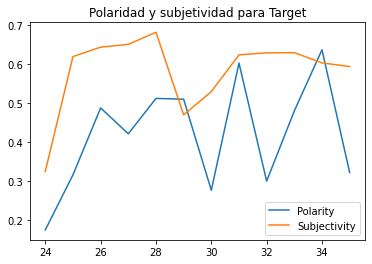

In [26]:
plt.plot(target['polarity']);
plt.plot(target['subjectivity']);
plt.legend(['Polarity', 'Subjectivity']);
plt.title('Polaridad y subjetividad para Target');
plt.savefig('targer.png')

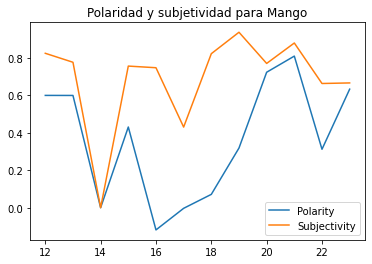

In [27]:
# Se toman los datos especificos de Mango
mango = data_completed.loc[data_completed['index'] == 'mango']
plt.plot(mango['polarity']);
plt.plot(mango['subjectivity']);
plt.legend(['Polarity', 'Subjectivity']);
plt.title('Polaridad y subjetividad para Mango');
plt.savefig('Mango.png')